# Acknowledgements
https://www.kaggle.com/allunia/pulmonary-dicom-preprocessing - DICOM preprocessing

https://www.kaggle.com/seraphwedd18/pe-detection-with-keras-model-creation - DICOM preprocessing

https://www.kaggle.com/redwankarimsony/rsna-str-pe-gradient-sigmoid-windowing/comments - DICOM windowing

In [1]:
import os
import random
import pydicom
import vtk
import cv2

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

import pylab as pl
import numpy as np
import pandas as pd

from pathlib import Path
from time import time
from vtk.util import numpy_support

In [2]:
DATA_ROOT = Path("../input/rsna-str-pulmonary-embolism-detection")
TEST_ROOT = DATA_ROOT/"test"

test_csv = pd.read_csv(DATA_ROOT/"test.csv")

In [3]:
reader = vtk.vtkDICOMImageReader()
def get_img(path):
    reader.SetFileName(path)
    reader.Update()
    _extent = reader.GetDataExtent()
    ConstPixelDims = [_extent[1]-_extent[0]+1, _extent[3]-_extent[2]+1, _extent[5]-_extent[4]+1]

    ConstPixelSpacing = reader.GetPixelSpacing()
    
    dcm_fields = [reader.GetRescaleSlope(), reader.GetRescaleOffset()]
    
    imageData = reader.GetOutput()
    pointData = imageData.GetPointData()
    arrayData = pointData.GetArray(0)
    ArrayDicom = numpy_support.vtk_to_numpy(arrayData)
    ArrayDicom = ArrayDicom.reshape(ConstPixelDims, order='F')
    ArrayDicom = cv2.resize(ArrayDicom,(512,512))
    return ArrayDicom, dcm_fields

In [4]:
def lung_window(img, dcm_fields):
    width = 1250
    length = -500
    window_min = length - (width/2)
    window_max = length + (width/2)
    slope, intercept = dcm_fields
    #img += np.abs(np.min(img))
    img = img * slope + intercept
    img[img < window_min] = window_min
    img[img > window_max] = window_max
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    #print(np.min(img), np.max(img))
    return img

def map_to_gradient(grey_img):
    rainbow_img = np.zeros((grey_img.shape[0], grey_img.shape[1], 3))
    rainbow_img[:, :, 0] = np.clip(4 * grey_img - 2, 0, 1.0) * (grey_img > 0) * (grey_img <= 1.0)
    rainbow_img[:, :, 1] =  np.clip(4 * grey_img * (grey_img <=0.75), 0,1) + np.clip((-4*grey_img + 4) * (grey_img > 0.75), 0, 1)
    rainbow_img[:, :, 2] = np.clip(-4 * grey_img + 2, 0, 1.0) * (grey_img > 0) * (grey_img <= 1.0)
    return rainbow_img

def rainbow_window(img, dcm_fields):
    grey_img = lung_window(img, dcm_fields)
    return map_to_gradient(grey_img)

def all_channels_window(img, dcm_fields):
    grey_img = lung_window(img, dcm_fields) * 3.0
    all_chan_img = np.zeros((grey_img.shape[0], grey_img.shape[1], 3))
    all_chan_img[:, :, 2] = np.clip(grey_img, 0.0, 1.0)
    all_chan_img[:, :, 0] = np.clip(grey_img - 1.0, 0.0, 1.0)
    all_chan_img[:, :, 1] = np.clip(grey_img - 2.0, 0.0, 1.0)
    return all_chan_img

In [5]:
studies = os.listdir(TEST_ROOT)

func = lambda x: int((2**15 + x)*(255/2**16))
int16_to_uint8 = np.vectorize(func)

def load_scans(dcm_path):
    # otherwise we sort by ImagePositionPatient (z-coordinate) or by SliceLocation
    slices = []
    fields = []
    for file in os.listdir(dcm_path):
        image, dcm_fields = get_img(dcm_path + "/" + file)
        #image = rainbow_window(image, dcm_fields)
        slices.append(image)
        fields.append(dcm_fields)

    return slices, fields

def filter_scanner(raw_pixelarrays):
    # in OSIC we find outside-scanner-regions with raw-values of -2000. 
    # Let's threshold between air (0) and this default (-2000) using -1000
    raw_pixelarrays[raw_pixelarrays <= -1000] = -1000
    return raw_pixelarrays

../input/rsna-str-pulmonary-embolism-detection/test/7588ef21167e/111f4ee890cf/f0d4e3971632.dcm
0.0
1.0


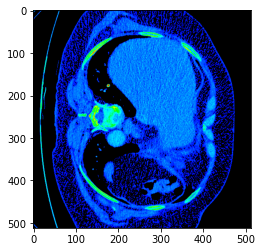

In [6]:
def load_scans_from_study(study):
    scans = []
    fields = []
    series = []
    for s in os.listdir(TEST_ROOT/study):
        series.append(s)
        scan_set, dcm_fields = load_scans(str(TEST_ROOT/study/s))
        scans.append(scan_set)
        fields.append(dcm_fields)
        
    return series, scans, fields

def load_individual_scan(scan_path):
    scan, fields = get_img(scan_path)
    scan = rainbow_window(scan, fields)
    return scan

idx = 90
study = studies[idx]
series = Path(os.listdir(TEST_ROOT/studies[idx])[0])
file = str((TEST_ROOT/studies[idx])/series/(os.listdir((TEST_ROOT/studies[idx])/series)[50]))
print(file)
image = load_individual_scan(file)
print(np.min(image))
print(np.max(image))
pl.imshow(image)
pl.show()

#print(tf.shape(load_scans_from_study(studies[0])[1]))

In [7]:
# Model definitions
        
batch_size = 16

def get_exam_model(rnn_units):
    return keras.Sequential([layers.Bidirectional(layers.GRU(rnn_units, return_sequences=True), input_shape=(None, 1280)),
                             layers.Bidirectional(layers.GRU(rnn_units, return_sequences=True)),
                             layers.Bidirectional(layers.GRU(rnn_units)),
                             layers.Dense(9, activation='sigmoid')])

image_inp = keras.Input(shape=(512, 512, 3))
image_out = keras.applications.EfficientNetB0(weights=None, include_top=False, pooling='avg')(image_inp)
image_pred = layers.Dense(1, activation='sigmoid')(image_out)
image_model = keras.Model(inputs=image_inp, outputs=[image_out, image_pred])
image_model.load_weights("../input/image-model-tfrecords/image_weights_8760.h5")
image_model.summary()

exam_model = get_exam_model(128)
exam_model.load_weights("../input/exam-weights/exam_weights.h5")
exam_model.summary()

@tf.function
def image_eval_step(image):
    #image = tf.convert_to_tensor(image)
    return image_model(image)

@tf.function
def exam_eval_step(images):
    return exam_model(images)

prediction_fields = ['negative_exam_for_pe', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',
                     'leftsided_pe', 'chronic_pe', 'rightsided_pe',
                     'acute_and_chronic_pe', 'central_pe', 'indeterminate']

submission = dict()

for i, study in enumerate(studies):
    t0 = time()
    #collected_images = tf.TensorArray(tf.float32, size=sum([len(os.listdir((TEST_ROOT/study)/series))
    #                                                        for series in os.listdir(TEST_ROOT/study)]))
    collected_images = []
    current_images = []
    predicted_images = []
    image_level_preds = []
    
    series = os.listdir(TEST_ROOT/study)
    for serie in series:
        current_serie_path = Path(serie)
        current_images = os.listdir(TEST_ROOT/study/serie)
        predicted_images += current_images
        for j in range(len(current_images)):
            image_path = str(TEST_ROOT/study/current_serie_path/current_images[j])
            image = load_individual_scan(image_path)
            image = tf.expand_dims(image, axis=0)
                
            image_logits, image_level_pred = image_eval_step(image)

            image_level_preds.append(tf.squeeze(image_level_pred))
            
            collected_images.append(tf.squeeze(image_logits))# = collected_images.write(j, tf.squeeze(image_logits))
            print(f"""Scan {j} of {len(current_images)},"""
                  f""" study {i} of {len(studies)}        \r""", end='')

    collected_images = tf.stack(collected_images, 0)#collected_images.stack()
    shape = collected_images.shape
    collected_images = tf.reshape(collected_images, (1, shape[0], shape[1]))
    exam_logits = exam_eval_step(collected_images)[0]
    
    for x, field in enumerate(prediction_fields):
        l = exam_logits[x].numpy()
        if np.isnan(l):
            print(collected_images)
            submission[study+"_"+field] = random.randint(0, 1)
        else:
            submission[study+"_"+field] = l
        
    for image, pred in zip(predicted_images, image_level_preds):
        l = pred.numpy()
        if np.isnan(l):
            print(collected_images)
            submission[image] = random.randint(0,1)
        else:
            submission[image] = l
        
    t1 = time()
    print(t1 - t0)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 4,008,829
Non-trainable params: 42,023
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 256)         1082880   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         296448    
___________________

In [8]:
submission = { 'id': list(submission.keys()), 'label': list(submission.values()) }
submission = pd.DataFrame.from_dict(submission)
submission.to_csv("submission.csv", index=False)
print(submission)

                                       id     label
0       425d85826689_negative_exam_for_pe  0.716520
1          425d85826689_rv_lv_ratio_gte_1  0.471959
2           425d85826689_rv_lv_ratio_lt_1  0.401982
3               425d85826689_leftsided_pe  0.335055
4                 425d85826689_chronic_pe  0.233849
...                                   ...       ...
152698                   5b18d3091e2e.dcm  0.000004
152699                   0faf1ffaf9a7.dcm  0.000004
152700                   370cef0008ca.dcm  0.000004
152701                   102dd08b3ce7.dcm  0.000005
152702                   6ffec2893e45.dcm  0.000004

[152703 rows x 2 columns]
